In [9]:
import folium
import h3
from shapely.geometry import Polygon, shape
import pandas as pd
import shapely
import numpy as np
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
import twint
import os
import time

In [4]:
# A GeoJSON object representing a bounding box for the region of interest

geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              68.02734375,
              23.725011735951796
            ],
            [
              70.048828125,
              20.427012814257385
            ],
            [
              72.333984375,
              20.879342971957897
            ],
            [
              72.6416015625,
              18.979025953255267
            ],
            [
              73.36669921875,
              16.024695711685315
            ],
            [
              74.55322265625,
              12.833226023521243
            ],
            [
              76.1572265625,
              9.167178732976677
            ],
            [
              77.32177734375,
              7.863381805309173
            ],
            [
              78.31054687499999,
              8.47237228290914
            ],
            [
              78.44238281249999,
              8.841651120809145
            ],
            [
              79.03564453124999,
              9.188870084473406
            ],
            [
              79.62890625,
              8.86336203355168
            ],
            [
              79.69482421875,
              7.36246686553575
            ],
            [
              79.73876953125,
              6.206090498573885
            ],
            [
              80.15625,
              5.68158368342113
            ],
            [
              81.73828125,
              6.293458760393985
            ],
            [
              82.08984375,
              7.536764322084078
            ],
            [
              81.123046875,
              9.167178732976677
            ],
            [
              80.13427734374999,
              10.120301632173907
            ],
            [
              79.98046875,
              11.673755403433413
            ],
            [
              80.44189453125,
              13.389619591747595
            ],
            [
              80.26611328125,
              15.284185114076433
            ],
            [
              81.10107421874999,
              15.749962572748768
            ],
            [
              82.3974609375,
              16.615137799987075
            ],
            [
              84.92431640625,
              19.103648251663646
            ],
            [
              86.59423828125,
              20.05593126519445
            ],
            [
              87.14355468749999,
              20.73556590521864
            ],
            [
              87.099609375,
              21.3303150734318
            ],
            [
              91.34033203125,
              21.94304553343818
            ],
            [
              92.3291015625,
              21.963424936844223
            ],
            [
              92.92236328125,
              21.94304553343818
            ],
            [
              94.50439453125,
              24.367113562651262
            ],
            [
              95.29541015625,
              26.194876675795218
            ],
            [
              97.3828125,
              27.059125784374068
            ],
            [
              97.6025390625,
              28.304380682962783
            ],
            [
              96.30615234375,
              29.49698759653577
            ],
            [
              94.5703125,
              29.439597566602902
            ],
            [
              91.845703125,
              28.110748760633534
            ],
            [
              89.69238281249999,
              28.420391085674304
            ],
            [
              87.16552734375,
              28.05259082333983
            ],
            [
              85.20996093749999,
              28.69058765425071
            ],
            [
              83.671875,
              29.592565403314087
            ],
            [
              82.2216796875,
              30.41078179084589
            ],
            [
              80.88134765625,
              31.015278981711266
            ],
            [
              79.5849609375,
              32.52828936482526
            ],
            [
              78.15673828125,
              35.37113502280101
            ],
            [
              75.30029296875,
              37.00255267215955
            ],
            [
              72.3779296875,
              36.61552763134925
            ],
            [
              71.25732421875,
              34.50655662164561
            ],
            [
              68.9501953125,
              31.297327991404266
            ],
            [
              65.93994140625,
              27.391278222579277
            ],
            [
              65.72021484375,
              25.46311452925943
            ],
            [
              68.02734375,
              23.725011735951796
            ]
          ]
        ]
      }
    }
  ]
}

In [5]:
# Add a 1 degree buffer around this area

s = shape(geojson['features'][0]['geometry'])
s = s.buffer(1)
feature = {'type': 'Feature', 'properties': {}, 'geometry': shapely.geometry.mapping(s)}
feature['geometry']['coordinates'] = [[[v[0], v[1]] for v in feature['geometry']['coordinates'][0]]]
feature = feature['geometry']
feature['coordinates'][0] = [[v[1], v[0]] for v in feature['coordinates'][0]]

In [7]:
# map H3 hexagons (code taken from H3 example: https://github.com/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb)

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

# find all hexagons with a center that falls within our buffered area of interest from above
polyline = feature['coordinates'][0]
polyline.append(polyline[0])
lat = [p[0] for p in polyline]
lng = [p[1] for p in polyline]
m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=6, tiles='cartodbpositron')
my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
m.add_child(my_PolyLine)

# make the list of hexagon IDs in our AOI
hexagons = list(h3.polyfill(feature, 3))

# map the hexagons
polylines = []
lat = []
lng = []
for hex in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0],polyline))
    lng.extend(map(lambda v:v[1],polyline))
    polylines.append(polyline)
for polyline in polylines:
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color='red')
    m.add_child(my_PolyLine)
display(m)

In [14]:
len(hexagons)

452

452 hexagons tile this area this zoom level. However, notice that some of them are fully over water, so not every area will have data.

In [12]:
np.sqrt((h3.cell_area(hexagons[0], unit='km^2')/0.827)/np.pi)

68.15279373567836

The ratio of the area of a regular hexagon to a circumscribed circle is 0.827. Scaling the area of each H3 cell by this factor can be used to find the radius of a circle that approximately circumscribes that cell. (This is approximate because H3 cells are not regular, as they must tile a sphere. In fact, some of them are pentagons. However, this approximation works for these purposes.

With this method, search queries can be automatically generated for each cell:

In [16]:
for hex in hexagons:
    center = h3.h3_to_geo(hex)
    r = np.sqrt((h3.cell_area(hex, unit='km^2')/0.827)/np.pi) 
    query = "(urgent OR help) AND geocode:" + str(center[0]) + "," + str(center[1]) + "," + str(r) + "km"
    
print("Example query:", query)

Example query: (urgent OR help) AND geocode:22.089682313298564,81.20150766588854,69.85968148546738km


Next, these locations and radii can be used to download tweets using TWINT.

In [123]:
os.mkdir('data_by_hex')

In [ ]:
# Download tweets using TWINT for each hexagon in the list
hexagons_left = hexagons

while len(hexagons_left) > 0:
    hex = hexagons_left.pop(0)
    
    if not os.path.exists('data_by_hex/' + hex + '.csv'):
        center = h3.h3_to_geo(hex)
        r = np.sqrt(h3.cell_area(hex, unit='km^2')*1.20919957616/np.pi) 
        query = "(urgent OR help) AND geocode:" + str(center[0]) + "," + str(center[1]) + "," + str(r) + "km"
        print(query)


        c = twint.Config()

        c.Search = query
        c.Store_csv = True
        c.Output = "data_by_hex/" + hex + ".csv"
        c.Hide_output = True
        c.Since = "2021-01-01"

        try:
            twint.run.Search(c)
        except:
            os.remove('data_by_hex/' + hex + '.csv')
            time.sleep(10)
            print('error, removing this one')
            hexagons_left.append(hex)
    
    print(len(hexagons_left), "remaining")

Now, tweets for each hexagon will be grouped by hour and counted. Data per day for each hexagon, and data per hexagon (center coordinates, radius, baseline tweet volume) will be constructed and saved to a CSV.

In [174]:
# To merge everything into a single DataFrame, it is helpful to start with the index we want to use ultimately.
# The easiest way to do this was just to use the same aggregation method that will eventually be applied to
# every search query in the dataset, and grab its index.

df = pd.read_csv('data_by_hex/' + '836181fffffffff' + '.csv', parse_dates=['created_at'])
grp = df.groupby(pd.Grouper(freq='1D', key='created_at'))

df = pd.DataFrame()
df['all'] = grp.count()['id']
del df['all']
tdf = df

# now "tdf" is an empty DataFrame that can be used to append columns to

In [134]:
# Next, this aggregation process is repeated for each file

# optionally, merge with a second set of files by specifying another directory here.
merge = False

for hex in hexagons:
    if os.path.exists('data_by_hex/' + hex + '.csv'):
        df = pd.read_csv('data_by_hex/' + hex + '.csv', parse_dates=['created_at'])
        
        if merge:
            df2 = pd.read_csv(merge + hex + '.csv', parse_dates=['created_at'])
            df = df.append(df2)
            df = df.drop_duplicates(subset=['id'])
            df = df.sort_values(by='created_at')
            df.index = range(len(df))
        
        # look for keywords and add as a column
        df['o2'] = df['tweet'].apply(lambda v: 'oxygen' in v.lower() or 'o2' in v.lower())

        try:
            grp = df.groupby(pd.Grouper(freq='1D', key='created_at'))
        except:
            # sometimes this groupby fails with a type issue
            df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
            grp = df.groupby(pd.Grouper(freq='1D', key='created_at'))

        df = pd.DataFrame()

        df['all'] = grp.count()['id']
        df['o2'] = grp.sum()['o2']

        # store this data as columns in our main DataFrame, tdf
        tdf[(hex, 'all')] = df['all']
        tdf[(hex, 'o2')] = df['o2']

# replace NaNs (caused when no tweets were aggregated for a time range) with 0
tdf = tdf.fillna(0)

In [180]:
# make a list of information about each hexagon, including the baseline average tweet volume.

lats = []
lons = []
rs = []
baselines = []

for hex in hexagons:
    r = np.sqrt(h3.cell_area(hex, unit='km^2')*1.20919957616/np.pi) 
    rs.append(r)

    loc = h3.h3_to_geo(hex)
    lats.append(loc[0])
    lons.append(loc[1])
    
    try:
        baseline = tdf[(hex, 'all')].mean()
    except:
        baseline = 0
    baselines.append(baseline)
    
hexes = pd.DataFrame()
hexes['lat'] = lats
hexes['lng'] = lons
hexes['r'] = rs
hexes['baseline'] = baselines
hexes.index = hexagons
hexes

,lat,lng,r,baseline,weights
8342e9fffffffff,25.604755,72.536284,68.800914,2.200000,2.060976
8342f3fffffffff,21.717278,68.237880,65.871140,0.000000,8.206186
833d8dfffffffff,26.995700,81.311909,68.723951,30.906667,6.742437
833c08fffffffff,28.506879,89.302672,69.306116,0.000000,8.206186
836092fffffffff,21.992150,78.158324,68.380089,0.440000,5.526316
...,...,...,...,...,...
833c00fffffffff,28.508304,86.005090,68.652271,0.000000,8.206186
8360b0fffffffff,18.439594,79.364650,70.140780,17.426667,6.504505
8360aafffffffff,16.895601,75.166881,68.040215,0.813333,5.636364
8342c3fffffffff,22.112095,71.271054,66.291994,3.813333,6.210526


In [181]:
# export both to CSV
tdf.to_csv('daily_weighted.csv')
hexes.to_csv('hexes_weighted.csv')

### A brief check on the distribution of the number of Twitter users

It is important to take a look at how many individual users are sampled in the dataset. If each hex cell contained tweets from only a handful of users, the data would be much less reliable than if it contained a wider sample.

In [ ]:
# Check to see if there were a substantial number of individual twitter users for each of the hex cells

users = {}

for hex in hexagons:
    if os.path.exists('/Users/loganw/Documents/india/' + hex + '.csv'):
        df = pd.read_csv('/Users/loganw/Documents/india/' + hex + '.csv', parse_dates=['created_at'])
        grp = df.groupby('username').count()
        users[hex] = len(grp)

(array([90., 39., 40., 19., 20., 15., 19.,  9.,  7.,  9.,  5.,  2.,  8.,
         6.,  8.,  6.,  3.,  1.,  4.,  2.,  3.,  3.,  4.,  2.,  0.,  0.,
         1.,  2.,  1.,  1.,  1.,  3.,  0.,  1.,  0.,  0.,  2.,  3.,  1.]),
 array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
         550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
        1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
        1650, 1700, 1750, 1800, 1850, 1900, 1950]),
 <BarContainer object of 39 artists>)

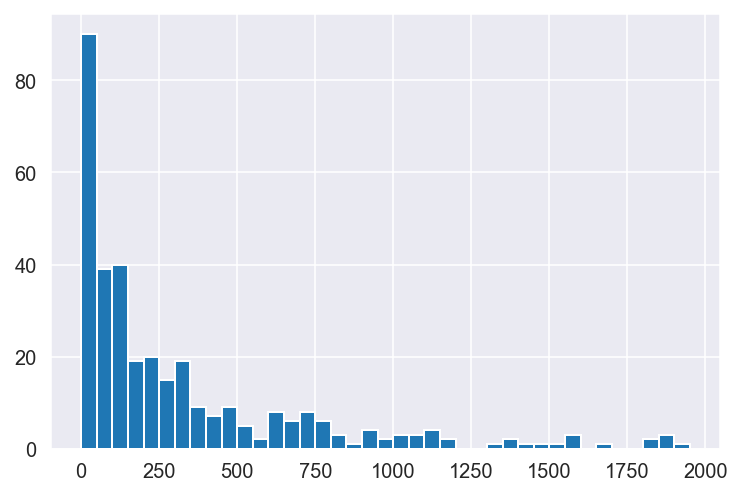

In [107]:
# Plot the distributon of user counts.
plt.hist(users.values(), np.arange(0, 2000, 50))

## Compensating for missing data

Some tweets are only included if the query is run within seven days of the tweet (those that match a geocoded search because of the user's profile location.) The following code computes how many tweets might be missing from older data in the TWINT aggregates. Specifically, it finds the ratio between users tweeting with a profile location OR places to users tweeting with places, for each grid cell, based on data available from multiple scraping sessions, separated by a certain amount of time.

In [ ]:
averages = []
stds = []
weighted = {}

for hex in hexagons:
    df = None
    
    if os.path.exists('path1/' + hex + '.csv') and os.path.exists('path2/' + hex + '.csv'):
        df2 = pd.read_csv('path1/' + hex + '.csv', parse_dates=['created_at'])
        df1 = pd.read_csv('path2/' + hex + '.csv', parse_dates=['created_at'])
        
        df1['created_at'] = pd.to_datetime(df1['created_at'], utc=True)
        df2['created_at'] = pd.to_datetime(df2['created_at'], utc=True)

        grp1 = df1.groupby(pd.Grouper(freq='1D', key='created_at'))
        grp2 = df2.groupby(pd.Grouper(freq='1D', key='created_at'))
        
        df = grp2.count()[['id']]
        df['old'] = grp1.count()['id']
        df = df.fillna(0)
        
        # compute the ratio of tweets captured by the "old" scraping session compared to those captured
        # by the "new" scraping session. For times in the past, this will be 1, and for times in the most
        # recenter 7 days, this will be 1, but in between, it will be larger than 1.
        ratio = np.array(df['old']) / np.array(df['id'])
        df['ratio'] = ratio
        
        # These indices would need to be adjusted for other data so that they contain the days when
        # df2 has a partial set of data, but df1 has a full set of data. For example, if df1 was
        # scraped on the 7th, and df2 was scraped on the 10th, this could include the 1st, 2nd, and 3rd.
        ratios = np.array(df.loc[df.index[-20:-13]]['ratio'])
        ratios = [r for r in ratios if r < 1000]
        
        avg_ratio = np.mean(ratios)
        std_ratio = np.std(ratios)
        weighted_ratio = df.loc[df.index[-20:-13]]['old'].sum() / df.loc[df.index[-20:-13]]['id'].sum()
                
        averages.append(avg_ratio)
        stds.append(std_ratio)
        
        weighted[hex] = weighted_ratio
        

In [179]:
weights = []

for h in hexes.index:
    if h in weighted and weighted[h] < 1000 and not np.isnan(weighted[h]):
        weights.append(weighted[h])
    else:
        weights.append(np.median([v for v in list(weighted.values()) if v < 1000 and not np.isnan(v)]))
    
# add this to our per-hex dataframe
hexes['weights'] = weights

In [171]:
np.median([v for v in list(weighted.values()) if v < 1000 and not np.isnan(v)])

8.206185567010309

<ErrorbarContainer object of 3 artists>

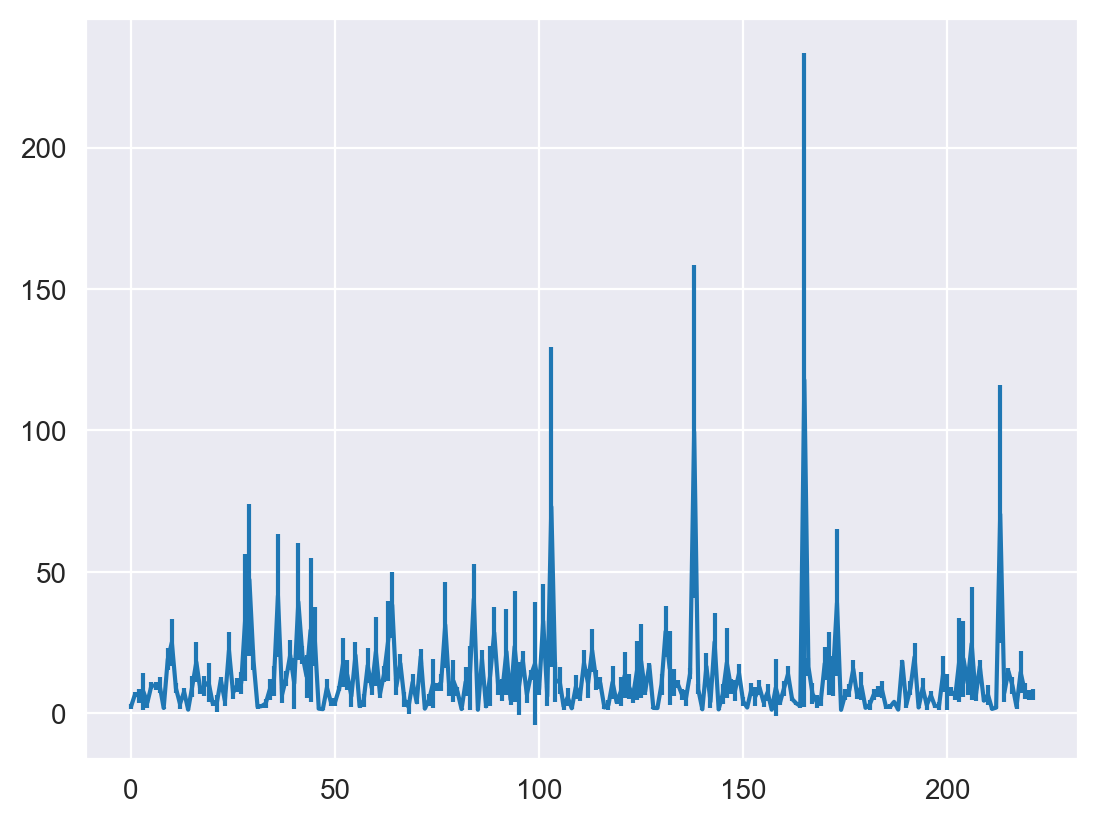

In [114]:
plt.errorbar(range(222), [a for a in averages if a < 10000 and not np.isnan(a)], yerr=[a for a in stds if a < 10000 and not np.isnan(a)])

As can be seen above, this ratio is highly variable. While the highest variance cells are likely to be those with very few tweets/users, which shouldn't be visualized anyway (and aren't in Bellingcat's visualization), this is still cause for concern. Consequentially **tweet volume from more than seven days ago cannot be directly compared with tweet volume from the most recent seven days, even with this attempted compensation method.** However, the relative frequency of specific terms within the dataset (for example, "oxygen") can be, though due to the smaller sample size, variance will be larger for older tweets.